In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="5"

# Solving Helmholtz problems

> The models used by the Helmholtz solvers are derived with [Santeri Kaupinmäki](https://bug.medphys.ucl.ac.uk/santeri-kaupinmaki)

Depending on the heterogeneity of the model, the Helmholtz solver automatically calls different functions to calculate the computationally cheapest Helmholtz operator. The solution is always found using an iterative linear solver with matrix-free linear operators.

In [3]:
from jax import numpy as jnp
from jax import jit

# Defining geometry
from jwave.geometry import kGrid, Medium, _circ_mask

N = (128, 256)
dx = (1., 1.)
omega = 1.

# Making geometry
grid = kGrid.make_grid(N, dx)

# Source field
src_field = jnp.zeros(N).astype(jnp.complex64)
src_field = src_field.at[64, 22].set(1.0)

# Speed of sound
sound_speed = jnp.zeros(N)
sound_speed = sound_speed.at[20:105,20:200].set(1.)
sound_speed = sound_speed*(1-_circ_mask(N, 90,[64,180]))*(1-_circ_mask(N,50,[64,22])) +1

## The Homogeneous density case
For a medium with homogeneous density and no attenuation, the wave equations is given as 

$$
\left( \nabla^2 - \frac{1}{c_0^2}\frac{\partial^2}{\partial t^2}\right)p = -\frac{\partial}{\partial t}S_M
$$

Taking the Fourier transform in time, and denoting the Fourier transform of a function $f$ as $\hat f$, one gets the Helmholtz equation

$$
\left( \nabla^2 + \frac{\omega^2}{c_0^2}\right)\hat p = -i\omega \hat S_M.
$$

Note that there both $\hat p$ and $\hat S_M$ are complex.

#### Perfectly matched layer
To enforce the Sommerfield radiation condition, the components of the gradient operator $\hat \nabla$ [are modified as](http://oomph-lib.maths.man.ac.uk/doc/pml_helmholtz/scattering/latex/refman.pdf)

$$
\frac{\partial}{\partial x_j} \to \frac{1}{\gamma_j} \frac{\partial}{\partial x_j},
\qquad
\gamma_j = 1 + \frac{1}{k_0}\sigma_j(x), \qquad \sigma_j(x)\frac{1}{\|x_j - x_j^{PML}\|^2}
$$

and the equations solved is 

$$
\left( \hat\nabla^2 + \frac{\omega^2}{c_0^2}\right)\hat p = -i\omega \hat S_M.
$$

In [4]:
# Medium properties
medium = Medium(
    sound_speed=sound_speed,
    density=None,
    attenuation=None,
    pml_size=15
)

In [5]:
from jwave.physics import solve_helmholtz

fast_solve = jit(lambda medium, src_field, omega, method: solve_helmholtz(
    grid, medium, src_field, omega, method=method
), static_argnums=(3,))

field = fast_solve(medium, src_field, omega, "bicgstab",).block_until_ready()

Text(0.5, 1.0, 'Wavefield magnitude')

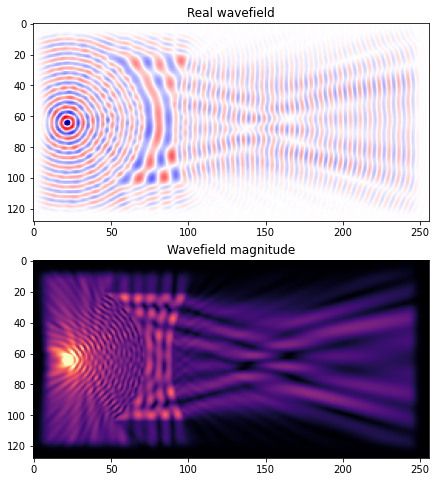

In [6]:
from matplotlib import pyplot as plt

fig, axes = plt.subplots(2,1,figsize=(15,8))

axes[0].imshow(field.real, vmin=-.2, vmax=.2, cmap="seismic")
axes[0].set_title("Real wavefield")
axes[1].imshow(jnp.abs(field), vmin=0, vmax=.1, cmap="magma")
axes[1].set_title("Wavefield magnitude")

## Heterogeneous density
For heterogeneous densities, we have to start from the conservation equations

$$
\begin{aligned}
\frac{\partial u}{\partial t} &= -\frac{1}{\rho_0}\nabla p \\
\frac{\partial \rho}{\partial t} &= -\rho_0 \nabla \cdot u - u \cdot \nabla \rho_0 + S_M\\
p &= c_0^2(\rho + d\cdot \nabla \rho_0)
\end{aligned}
$$

Taking them together gives

$$
\left[\rho_0\nabla\cdot \left( \frac{1}{\rho_0}\nabla \right)-\frac{1}{c_0^2}\frac{\partial^2}{\partial t^2}\right]\hat p = - \frac{\partial S_M}{\partial t}
$$

The Fourier transform of this expression gives the Helmholtz equation with heterogeneous density

$$
\left[\rho_0\nabla\cdot \left( \frac{1}{\rho_0}\nabla \right)+\frac{\omega^2}{c_0^2}\right]\hat p = -i\omega \hat S_M.
$$

In [7]:
density = jnp.ones(N)
density = density.at[:64, 170:].set(1.5)

medium = Medium(
    sound_speed=sound_speed,
    density=density,
    attenuation=None,
    pml_size=15
)

In [8]:
field = fast_solve(medium, src_field, omega, "bicgstab").block_until_ready()

Text(0.5, 1.0, 'Wavefield magnitude')

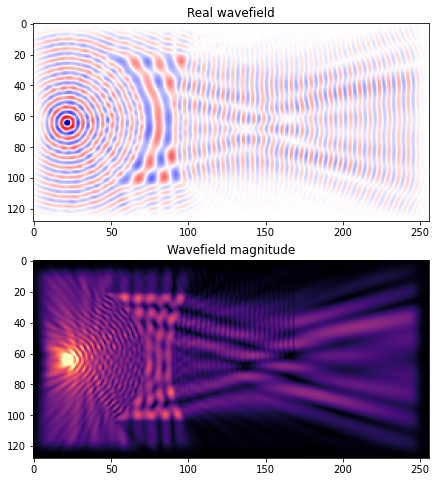

In [9]:
fig, axes = plt.subplots(2,1,figsize=(15,8))

axes[0].imshow(field.real, vmin=-.2, vmax=.2, cmap="seismic")
axes[0].set_title("Real wavefield")
axes[1].imshow(jnp.abs(field), vmin=0, vmax=.1, cmap="magma")
axes[1].set_title("Wavefield magnitude")

## Attenuation
If attenuation is modeled using Stokes absorption, the Helmholtz equation is given by 

$$
\left[(1 + i\tau \omega)\nabla^2 + \frac{\omega^2}{c_0^2}\right]\hat p =  \left(\omega^2\tau- i\omega\right)S_M
$$

In [10]:
attenuation = jnp.zeros(N)
attenuation = attenuation.at[64:110,125:220].set(0.02)

medium = Medium(
    sound_speed=sound_speed,
    density=None,
    attenuation=attenuation,
    pml_size=15
)

In [11]:
from jwave.physics import solve_helmholtz

fast_solve = jit(lambda medium, src_field, omega, method: solve_helmholtz(
    grid, medium, src_field, omega, method=method
), static_argnums=(3,))

field = fast_solve(medium, src_field, omega, "bicgstab").block_until_ready()

Text(0.5, 1.0, 'Wavefield magnitude')

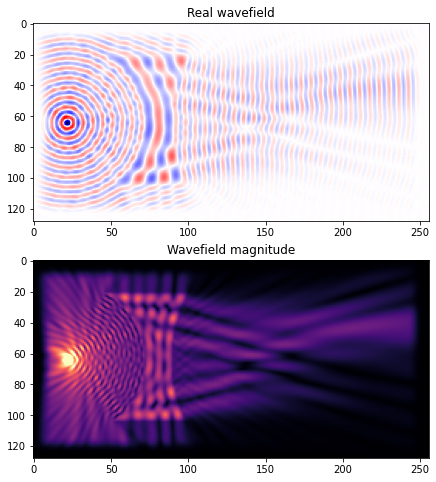

In [12]:
fig, axes = plt.subplots(2,1,figsize=(15,8))

axes[0].imshow(field.real, vmin=-.2, vmax=.2, cmap="seismic")
axes[0].set_title("Real wavefield")
axes[1].imshow(jnp.abs(field), vmin=0, vmax=.1, cmap="magma")
axes[1].set_title("Wavefield magnitude")

# Monochromatic simulations

In [13]:
from jax import numpy as jnp
from jax import jit

In [14]:
# Defining geometry
from jwave.geometry import kGrid, Medium, _circ_mask

N = (128, 256)
dx = (1., 1.)
omega = 1.

# Making geometry
grid = kGrid.make_grid(N, dx)

# Physical properties
sound_speed = jnp.zeros(N)
sound_speed = sound_speed.at[20:105,20:200].set(1.)
sound_speed = sound_speed*(1-_circ_mask(N, 90,[64,180]))*(1-_circ_mask(N,50,[64,22])) +1

attenuation = jnp.zeros(N)
attenuation = attenuation.at[64:,125:].set(0.01)

density = jnp.ones(N)
density = density.at[:64, 170:].set(1.5)

medium = Medium(
    sound_speed=sound_speed,
    density=density,
    attenuation=attenuation,
    pml_size=15
)

# Source field
src_field = jnp.zeros(N).astype(jnp.complex64)
src_field = src_field.at[64, 22].set(1.0)

In [15]:
from jwave.physics import solve_helmholtz

fast_solve = jit(lambda medium, src_field, omega, method: solve_helmholtz(
    grid, medium, src_field, omega, method=method
), static_argnums=(3,))

field = fast_solve(medium, src_field, omega, "bicgstab")
field = fast_solve(medium, src_field, omega, "gmres")

Text(0.5, 1.0, 'Wavefield magnitude')

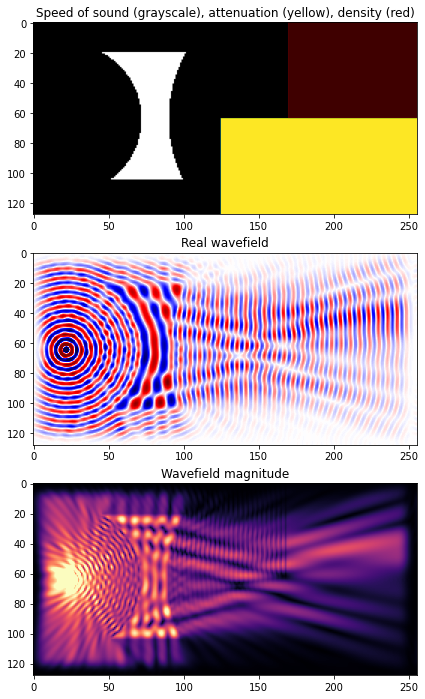

In [16]:
from matplotlib import pyplot as plt

fig, axes = plt.subplots(3,1,figsize=(17,12))

field = field/jnp.amax(jnp.abs(field))
axes[0].imshow(medium.sound_speed, cmap="gray")
axes[0].imshow(attenuation, alpha=attenuation*100)
axes[0].imshow(density-1, alpha=(density-1), cmap="seismic")
axes[0].set_title("Speed of sound (grayscale), attenuation (yellow), density (red)")
axes[1].imshow(field.real, vmin=-.2, vmax=.2, cmap="seismic")
axes[1].set_title("Real wavefield")
axes[2].imshow(jnp.abs(field), vmin=0, vmax=.2, cmap="magma")
axes[2].set_title("Wavefield magnitude")

# Runtimes

According to [Eerlanga](https://epubs.siam.org/doi/pdf/10.1137/040615195), Bi-CGSTAB is to be preferred to GMRES not only for memory requirements (the number of vectors in memory is fixed to 7, rather than variable as in restarted GMRES), but also because of faster convergence.

Let's check if that's true for Fourier spectral discretization too:

In [17]:
print("Runtime with GMRES")
%timeit fast_solve(medium, src_field, omega, "gmres").block_until_ready()

Runtime with GMRES
1.45 s ± 18.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
print("Runtime with Bi-CGSTAB")
%timeit fast_solve(medium, src_field, omega, "bicgstab").block_until_ready()

Runtime with Bi-CGSTAB
914 ms ± 35.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## References

